In [1]:
import torch
import numpy as np
import numpy.random as rd
import time
import argparse
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter

import copy
from torch.optim.lr_scheduler import StepLR

from tqdm import tqdm

from matplotlib import pyplot as plt
import matplotlib

In [2]:
from deepR_training import *

In [3]:
import os, sys
sys.path.append('../../Society of Mind/common/')
from datasets_and_tasks import DoubleMNIST, get_continual_task
from utils_diverse import plot_grid, plot_running_data

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
n

NameError: name 'n' is not defined

## Classical Training

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

class FFNet(nn.Module):
    def __init__(self, double=False):
        super(FFNet, self).__init__()
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(784*(1 + double), 300)
        self.fc2 = nn.Linear(300, 100)
        self.fc3 = nn.Linear(100, 10)
        
    def forward(self, x) : 
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)
        return output
        
def train_classic(model, device, train_loader, optimizer, epoch):
    model.train()
    desc = f'Epoch = {epoch}, Training: '
    for batch_idx, (data, target) in tqdm(enumerate(train_loader), position=0, desc=desc):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
       
        desc = str('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test_classic(model, device, test_loader, verbose=True):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    if verbose : print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))






In [ ]:
params = batch_size, epochs, lr, gamma, log_interval = 10, 15, 1, 0.7, 10
params_dict = {'batch_size' : batch_size, 'n_epochs' : epochs, 'lr' : lr, 'gamma' : gamma}

In [ ]:
use_cuda = False

torch.manual_seed(42)

device = torch.device("cuda" if use_cuda else "cpu")

train_kwargs = {'batch_size': params_dict['batch_size']}
test_kwargs = {'batch_size': params_dict['batch_size']}
if use_cuda:
    cuda_kwargs = {'num_workers': 0,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])
dataset1 = datasets.MNIST('../Data/MNIST', train=True, download=False,
                   transform=transform)
dataset2 = datasets.MNIST('../Data/MNIST', train=False,
                   transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)




model = FFNet().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=params_dict['lr'])

scheduler = StepLR(optimizer, step_size=1, gamma=params_dict['gamma'])
for epoch in range(1, params_dict['n_epochs'] + 1):
    train_classic(model, device, train_loader, optimizer, epoch)
    test_classic(model, device, test_loader)
    scheduler.step()

## Achieving Modularity though connection costs

In [39]:
class SmoothStep(torch.autograd.Function):
    '''
    Modified from: https://pytorch.org/tutorials/beginner/examples_autograd/two_layer_net_custom_function.html
    '''

    @staticmethod
    def forward(aux, x, thr=0):
        aux.save_for_backward(x)
        return (x >thr).type(x.dtype)

    def backward(aux, grad_output):
        # grad_input = grad_output.clone()
        input, = aux.saved_tensors
        grad_input = grad_output.clone()
        grad_input[input <= -.5] = 0
        grad_input[input > .5] = 0
        return grad_input
    
smooth_step = SmoothStep().apply

#------ Surrogate Gradient------


class SurrGradSpike(torch.autograd.Function):
    """
    Here we implement our spiking nonlinearity which also implements 
    the surrogate gradient. By subclassing torch.autograd.Function, 
    we will be able to use all of PyTorch's autograd functionality.
    Here we use the normalized negative part of a fast sigmoid 
    as this was done in Zenke & Ganguli (2018).
    """
    
    scale = 1.0 # controls steepness of surrogate gradient

    @staticmethod
    def forward(ctx, input, thr=0):
        """
        In the forward pass we compute a step function of the input Tensor
        and return it. ctx is a context object that we use to stash information which 
        we need to later backpropagate our error signals. To achieve this we use the 
        ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > thr] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor we need to compute the 
        surrogate gradient of the loss with respect to the input. 
        Here we use the normalized negative part of a fast sigmoid 
        as this was done in Zenke & Ganguli (2018).
        """
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input/(SurrGradSpike.scale*torch.abs(input)+1.0)**2

        return grad
        
super_spike  = SurrGradSpike.apply

#diffs = lambda shape, device: torch.tensor([[-1 +2*(i/shape[1]-j/shape[0])**2 for i in range(shape[1])] for j in range(shape[0])]).to(device)
#diffs = lambda shape, device: torch.tensor([[-1 + 2*np.abs(i/shape[1]-j/shape[0]) for i in range(shape[1])] for j in range(shape[0])]).to(device)
def diffs(theta) : 
    shape, device = theta.shape, theta.device
    shape_M, idx_M = max(shape), shape.index(max(shape))
    shape_m, idx_m = min(shape), shape.index(min(shape))
    
    idxs = torch.arange(shape_M).unsqueeze(idx_m).expand(shape_M, shape_M)
    diff = ((idxs/shape_M  - (idxs.T/shape_m)).abs())**(1)
    diff = diff[:, :shape_m]
    if idx_m == 0 : 
        diff = diff.T
    return diff.to(device)
    
costs = lambda theta: diffs(theta)*super_spike(theta)

def reg_cost(thetas) : 
    if (type(thetas) is not list) and (type(thetas) is not nn.ParameterList) : 
        thetas = [thetas, 0]
    return torch.stack([costs(t)[super_spike(t).bool()].mean() for t in thetas[:-1]]).sum()

def make_diag(theta, clone=True) : 
    shape = theta.shape
    shape_M, idx_M = max(shape), shape.index(max(shape))
    shape_m, idx_m = min(shape), shape.index(min(shape))
    
    diag = theta.data
    if clone : diag = diag.clone()
    diag[:shape_M//2, shape_m//2:] = 0
    diag[shape_M//2:, :shape_m//2] = 0
    return diag

In [55]:
sparse = True
double_training = True
task = 'continual'

soft_deepR = False
global_rewire = False #not soft_deepR

assert(not (soft_deepR and global_rewire))

batch_size = 256
n_epochs = 100

n_pixels = 28 * 28 + 28*28*double_training
n_1 = 300
n_2 = 100
n_out = 10 + 90*double_training*(task=='parity_digits_100' or task=='none')

dims = [n_pixels, n_1, n_2, n_out]
n_connect = [d1*d2 for (d1, d2) in zip(dims[1:], dims[:-1])]
n_layers = len(n_connect)
n_total = np.sum(np.array(n_connect))

p_connected = 0.01
p_last = 0.25
n_con = (n_total - n_connect[-1])*p_connected

#percentage_list = [0.75, 2.3, 22.8]
#sparsity_list = [p*p_connected for p in percentage_list]

proportions = [2., 1]
repartitions = [p/(sum(proportions)) for p in proportions]

percentage_list = [r*n_con/n for n, r in zip(n_connect[:-1], repartitions)] + [p_last]
#percentage_list = [p_connected for r in repartitions] + [p_last]

sparsity_list = percentage_list

#soft_sparsity_list = [p_connected]*(n_layers -1) + [p_last]

deepR_params = l1, lr, gamma = 1e-5, 1e-1, 0.9

T = lr*l1**2/18
gdnoise = np.sqrt(2*T*lr)/lr

deepR_params_dict = {'l1' : l1, 'gdnoise' : gdnoise, 'lr' : lr, 'gamma' : gamma}
# Define useful constants
dtype = torch.float32

transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])
use_cuda = True

device = torch.device("cuda" if use_cuda else "cpu")

train_kwargs = {'batch_size': batch_size}
test_kwargs = {'batch_size': batch_size}
if use_cuda:
    cuda_kwargs = {'num_workers': 0,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)
    
simple_datasets = [datasets.MNIST('../../Data/MNIST', train=train, download=False,
                   transform=transform) for train in [True, False]]
simple_loaders = [torch.utils.data.DataLoader(d, **train_kwargs) for d in simple_datasets]

double_datasets = [DoubleMNIST(train=train, asym=False) for train in [True, False]]
double_loaders = [torch.utils.data.DataLoader(d, **train_kwargs) for d in double_datasets]

if sparse : 
    if not soft_deepR : 
        net = Sparse_Net(dims, sparsity_list).to(device)
    else : 
        #clip_vals = np.array([-2e-5, -7e-6, -1e-6]) # np.array([-2e-5, -7e-6, -1e-6])*20~[1.7, 11, 35]% (l1=1e-5, lr=0.5)
        clip_vals = [None for _ in range(n_layers)]
        net = Sparse_Net_Soft(dims, sparsity_list, l1, gdnoise, lr, clip_vals=clip_vals)
else: 
    net = FFNet(double=double_training)

optimizer = optim.SGD(net.parameters(), lr=deepR_params_dict['lr'], momentum=0.)
#optimizer = optim.Adam(net.parameters(), lr=1e-3)

criterion = F.cross_entropy
cost_fn = reg_cost, diffs
scheduler = StepLR(optimizer, step_size=1, gamma=deepR_params_dict['gamma'])

loaders = simple_loaders if not double_training else double_loaders
net.nb_active, [f'{(t>0).float().mean().cpu().data.item()*100:.2f}' for t in net.thetas[:]]


([tensor(3325, device='cuda:0'),
  tensor(1626, device='cuda:0'),
  tensor(220, device='cuda:0')],
 ['0.71', '5.42', '22.00'])

In [56]:
train_out = train(net, *loaders, n_epochs, criterion, optimizer, scheduler, deepR_params_dict, task=task, cost_fn=cost_fn, global_rewire=global_rewire, soft_rewire=soft_deepR)
train_losses, (test_losses, test_accs), nb_reconnects = train_out

Epoch = 0, Training:   0%|          | 0/100 [00:00<?, ?it/s]

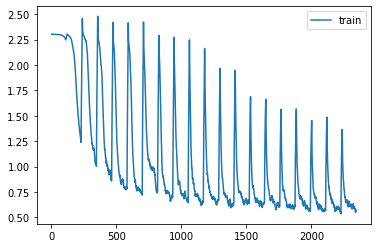

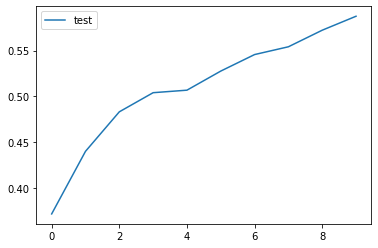

In [23]:
plt.figure()
plot_running_data(train_losses, m=10, label='train')
plt.figure()
plot_running_data(test_accs, m=1, label='test')

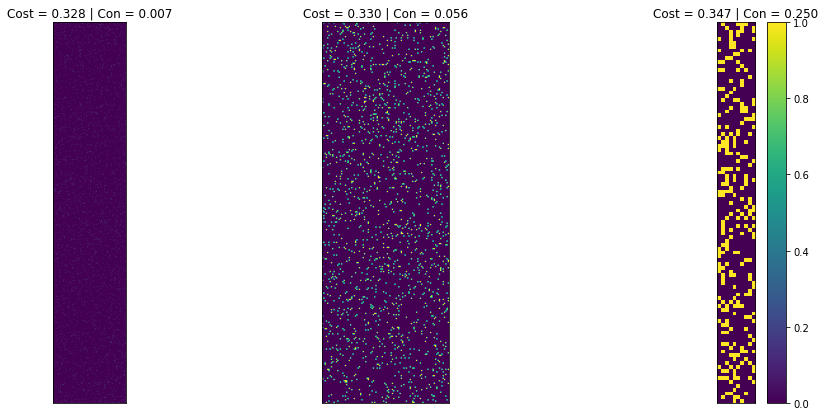

In [31]:
diag = False
f = (lambda t : make_diag(t, True)) if diag else (lambda x : x )

imgs = [f((t>0)).float().cpu().data.unsqueeze(0) for t in net.thetas]
labels = [f'Cost = {reg_cost(f(t)).cpu().data.item():.3f} | Con = {(t>0).float().mean():.3f}' for t in net.thetas]
plot_grid(imgs, labels, figsize=(15, 7))


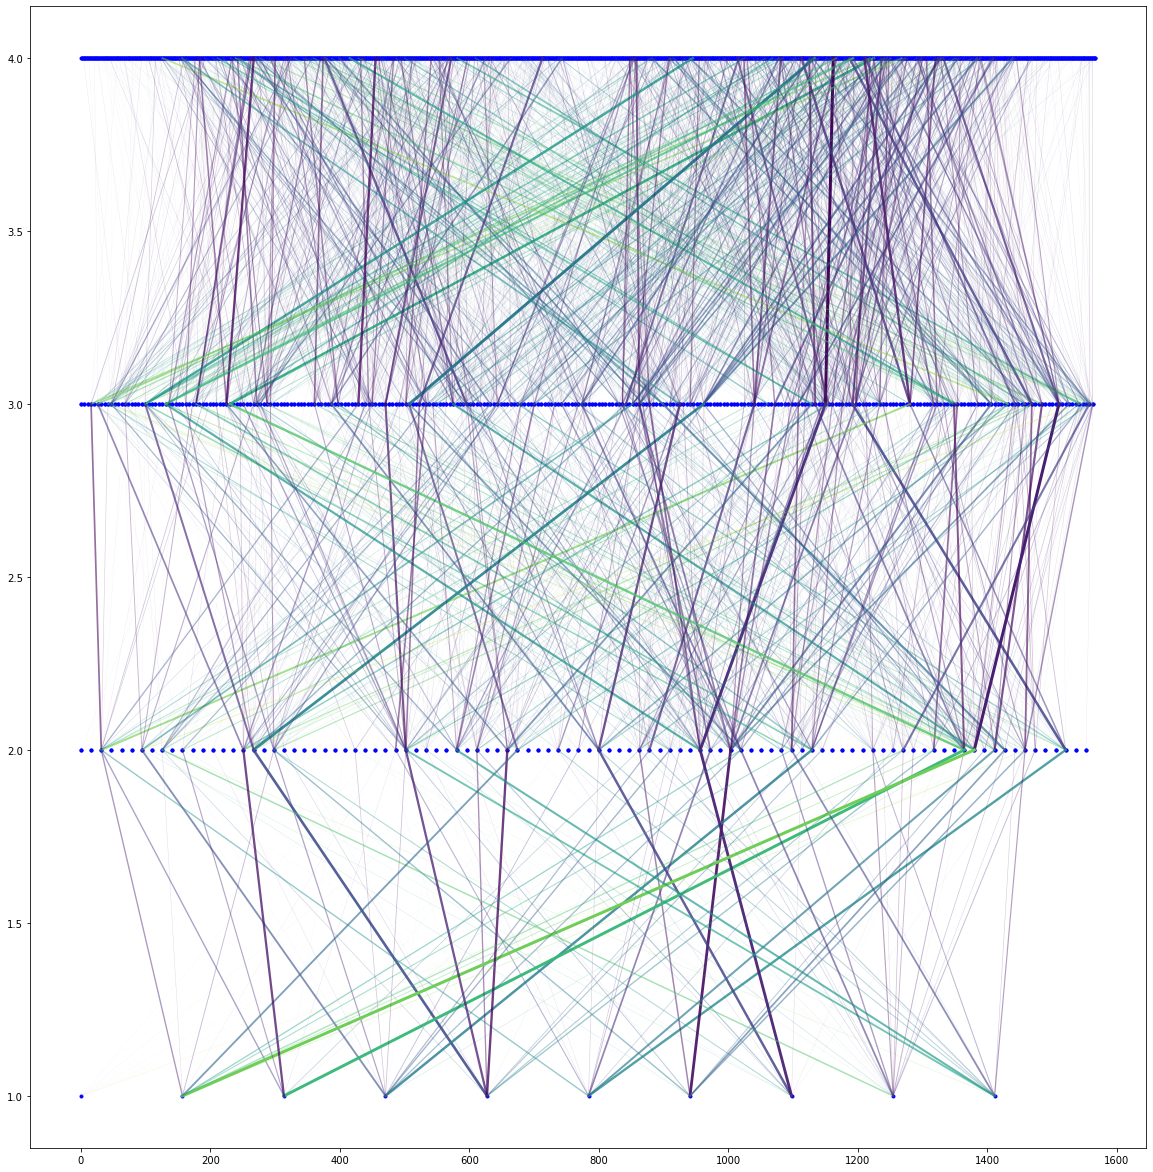

In [26]:
start = 0
end = 3
cmap = matplotlib.cm.get_cmap('viridis')

shapes = [t.shape for t in net.thetas]
middle = lambda shape : (shape[0] - shape[1])/2

def plot_layer(l=start) : 
    theta = net.thetas[l]
    diff = diffs(theta.shape, 'cpu')
    
    shape = theta.shape    
    transfo_0 = lambda array, l: ((array)*shapes[start][0]/(shapes[l][0]))
    transfo_1 = lambda array, l: ((array)*shapes[start][0]/(shapes[l][1]))
        
    plt.scatter(transfo_0(np.arange(shape[0]), l), [n_layers - (l-1) for _ in range(shape[0])], c='b', marker='.')
    plt.scatter(transfo_1(np.arange(shape[1]), l) , [n_layers-l for _ in range(shape[1])], c='b', marker='.')
    
    range_1 = list(range(shape[0]))
    range_2 = list(range(shape[1]))
    np.random.shuffle(range_1), np.random.shuffle(range_2)

    for i in range_1 : 
        for j in range_2 : 
            if (theta[i, j]>0): 
                
                alpha = (theta[i, j]/theta.max()).cpu().data.item()
                
                c = cmap(diff[i, j].item())
                width = (3*p_connected/0.01)*(theta[i, j]/theta.max()).cpu().data.item()
                
                plot = plt.plot([transfo_0(i, l), transfo_1(j, l)], [n_layers - (l-1), n_layers-l], '-', alpha=alpha, c=c, linewidth=width)
        
    return plot
  
fig = plt.figure(1, figsize=(20, 7*(end-start)))
for l in range(start, end) : 
    plot = plot_layer(l)
    ""

plt.show()


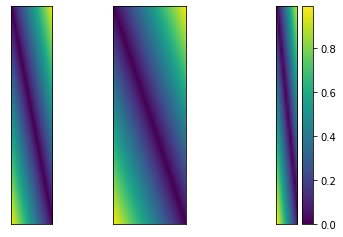

In [32]:
plot_grid([diffs(t.shape, t.device).cpu().data.unsqueeze(0) for t in net.thetas ])

In [ ]:
#p_test = torch.nn.Parameter(torch.rand(100, 100))
#p_test.data.uniform_(-1, 1)
sparsity_list[-1] = 0.1

if not soft_deepR : 
    net = Sparse_Net(dims, sparsity_list).to(device)
else : 
    #clip_vals = np.array([-2e-5, -7e-6, -1e-6]) # np.array([-2e-5, -7e-6, -1e-6])*20~[1.7, 11, 35]% (l1=1e-5, lr=0.5)
    clip_vals = [None for _ in range(n_layers)]
    net = Sparse_Net_Soft(dims, sparsity_list, l1, gdnoise, lr, clip_vals=clip_vals)
    
p_test = net.thetas[-1]
plot_grid([(p_test>0).cpu().data.unsqueeze(0)], [reg_cost([p_test, 0]).cpu().data.item()])
losses = []
optimizer = optim.SGD([p_test], lr=0.1, momentum=0.)
best_loss = 1e10
#deepR_params_dict['gdnoise'] = 1e-2
for _ in tqdm(range(1000)) : 
    loss = reg_cost(p_test)
    losses.append(loss.cpu().data.item())
    loss.backward()
        
    apply_grad(p_test, deepR_params_dict, soft=soft_deepR)
    optimizer.step()
    
    if soft_deepR :
        rewiring_soft(p_test, net.th_clips[-1]) 
    else :
        #nb_reconnect = sample_matrix_specific_reconnection_number_for_global_fixed_connectivity(net.thetas, net.sparsity_list)[-1]
        #rewiring_global(p_test, nb_reconnect)
        rewiring(p_test, net.nb_non_zero_list[-1])
    
    if loss < best_loss : 
        best_loss = loss
        best_model = copy.deepcopy(net)
        
    #print(net.nb_active[-1])
    
    #print(net.nb_active[-1])
    
plot_grid([(p_test>0).cpu().data.unsqueeze(0)], [reg_cost([p_test, 0]).cpu().data.item()])


In [ ]:
plot_running_data(losses, m=10)

In [ ]:
p_best = best_model.thetas[-1]
plot_grid([(p_best>0).cpu().data.unsqueeze(0)], [reg_cost([p_best, 0]).cpu().data.item()])
